# Spam Model using Keras
## Imports

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt


2022-09-25 02:08:00.750536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 02:08:00.910339: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-25 02:08:01.476857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-25 02:08:01.476965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Import dataset and normalize

In [2]:
# Read data
data = pd.read_csv('./input/MatrixData', sep='\t')
# Convert label to something useful
data.dropna(inplace=True)
def change_labels(x): return 1 if x == "spam" else 0
data['label'] = data['label'].apply(change_labels)

sentences = data['message'].tolist()
labels = data['label'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Tokenize

In [3]:
vocab_size = 600
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type,
                       truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunc_type)

## Model

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(.3,),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(.3,),
    tf.keras.layers.Dense(6, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(.3,),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam', metrics=['accuracy'])
model.summary()


2022-09-25 02:08:02.693840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           9600      
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dropout_2 (Dropout)         (None, 6)                 0         
                                                        

2022-09-25 02:08:02.722523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-25 02:08:02.722576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-25 02:08:02.723826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 02:08:02.724230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built witho

### Train

In [5]:
from datetime import datetime
from tensorflow import keras
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
# Define the checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
# Define the name of the checkpoint files.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [6]:
num_epochs = 200
history = model.fit(padded, 
                    training_labels_final, 
                    epochs=num_epochs, 
                    verbose=0, 
                    callbacks=[tensorboard_callback, 
                                tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                                   save_weights_only=True),
                    ],
                    validation_data=(testing_padded, testing_labels_final))

print("Average test loss: ", np.average(history.history['loss']))


Average test loss:  0.060539308656007054


INFO:tensorflow:Assets written to: ./models/spam_keras_1664064732.8198986/assets


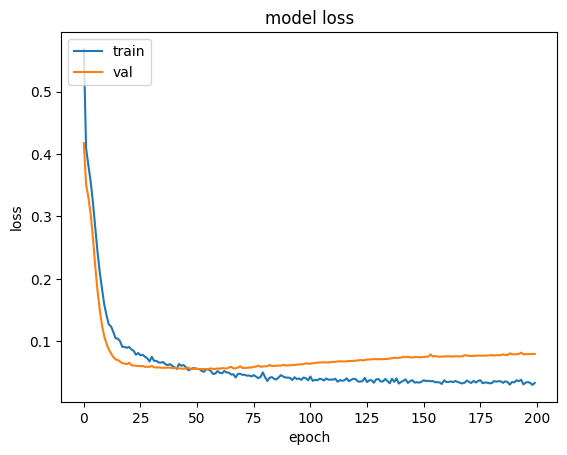

In [7]:
# Save model
import time
model.save(f"./models/spam_keras_{time.time()}")

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
# Use the model to predict whether a message is spam
text_messages = ['Greg, can you call me back once you get this?',
                 'Congrats on your new iPhone! Click here to claim your prize...',
                 'Really like that new photo of you',
                 'Did you hear the news today? Terrible what has happened...',
                 'Attend this free COVID webinar today: Book your session now...',
                 'Are you coming to the party tonight?',
                 'Your parcel has gone missing',
                 'Do not forget to bring friends!',
                 'You have won a million dollars! Fill out your bank details here...',
                 'Looking forward to seeing you again',
                 'oh wow https://github.com/MGCodesandStats/tensorflow-nlp/blob/master/spam%20detection%20tensorflow%20v2.ipynb works really good on spam detection. Guess I go with that as the base model then lol :D']

print(text_messages)

# Create the sequences
padding_type = 'post'
sample_sequences = tokenizer.texts_to_sequences(text_messages)
fakes_padded = pad_sequences(
    sample_sequences, padding=padding_type, maxlen=max_length)

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(text_messages)):
  print(text_messages[x])
  print(classes[x])
  print('\n')


['Greg, can you call me back once you get this?', 'Congrats on your new iPhone! Click here to claim your prize...', 'Really like that new photo of you', 'Did you hear the news today? Terrible what has happened...', 'Attend this free COVID webinar today: Book your session now...', 'Are you coming to the party tonight?', 'Your parcel has gone missing', 'Do not forget to bring friends!', 'You have won a million dollars! Fill out your bank details here...', 'Looking forward to seeing you again', 'oh wow https://github.com/MGCodesandStats/tensorflow-nlp/blob/master/spam%20detection%20tensorflow%20v2.ipynb works really good on spam detection. Guess I go with that as the base model then lol :D']
1/1 [==============================] - 0s 90ms/step
Greg, can you call me back once you get this?
[0.00112012]


Congrats on your new iPhone! Click here to claim your prize...
[0.9996164]


Really like that new photo of you
[0.00250836]


Did you hear the news today? Terrible what has happened...
[0.0